# Imports

In [1]:
import os
import time
import copy
import numpy as np
from zipfile import ZipFile
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data.dataloader import DataLoader

import torchvision
from torchvision import datasets, models, transforms
from torchvision.datasets import ImageFolder

# Download Dataset

In [2]:
file={"username":"mojtabanafez","key":"7c0ebd541704e0cb4357c05f78ed5fa2"}
import json
with open('kaggle.json', 'w') as fp:
    json.dump(file, fp)
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d jutrera/stanford-car-dataset-by-classes-folder

100% 1.82G/1.83G [00:15<00:00, 150MB/s]
100% 1.83G/1.83G [00:15<00:00, 126MB/s]


In [4]:
!unzip -q /content/stanford-car-dataset-by-classes-folder.zip

# Create Generator

In [5]:
TRAIN_DATA_PATH = "./car_data/car_data/train"
TEST_DATA_PATH = "./car_data/car_data/test"

TRANSFORM_IMG =  transforms.Compose(
    [
      transforms.ToTensor(), 
      transforms.Resize(size=(224,224)),
     ])

BATCH_SIZE=32

train_data = torchvision.datasets.ImageFolder(root=TRAIN_DATA_PATH, transform=TRANSFORM_IMG)
train_data_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True,  num_workers=2)

test_data = torchvision.datasets.ImageFolder(root=TEST_DATA_PATH, transform=TRANSFORM_IMG)
test_data_loader  = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=2) 

In [6]:
len(train_data_loader), len(test_data_loader)

(255, 252)

In [7]:
dl=iter(train_data_loader)
x, y= next(dl)
x.shape, y.shape, torch.mean(x), torch.min(x), torch.max(x)

(torch.Size([32, 3, 224, 224]),
 torch.Size([32]),
 tensor(0.4245),
 tensor(0.),
 tensor(1.))

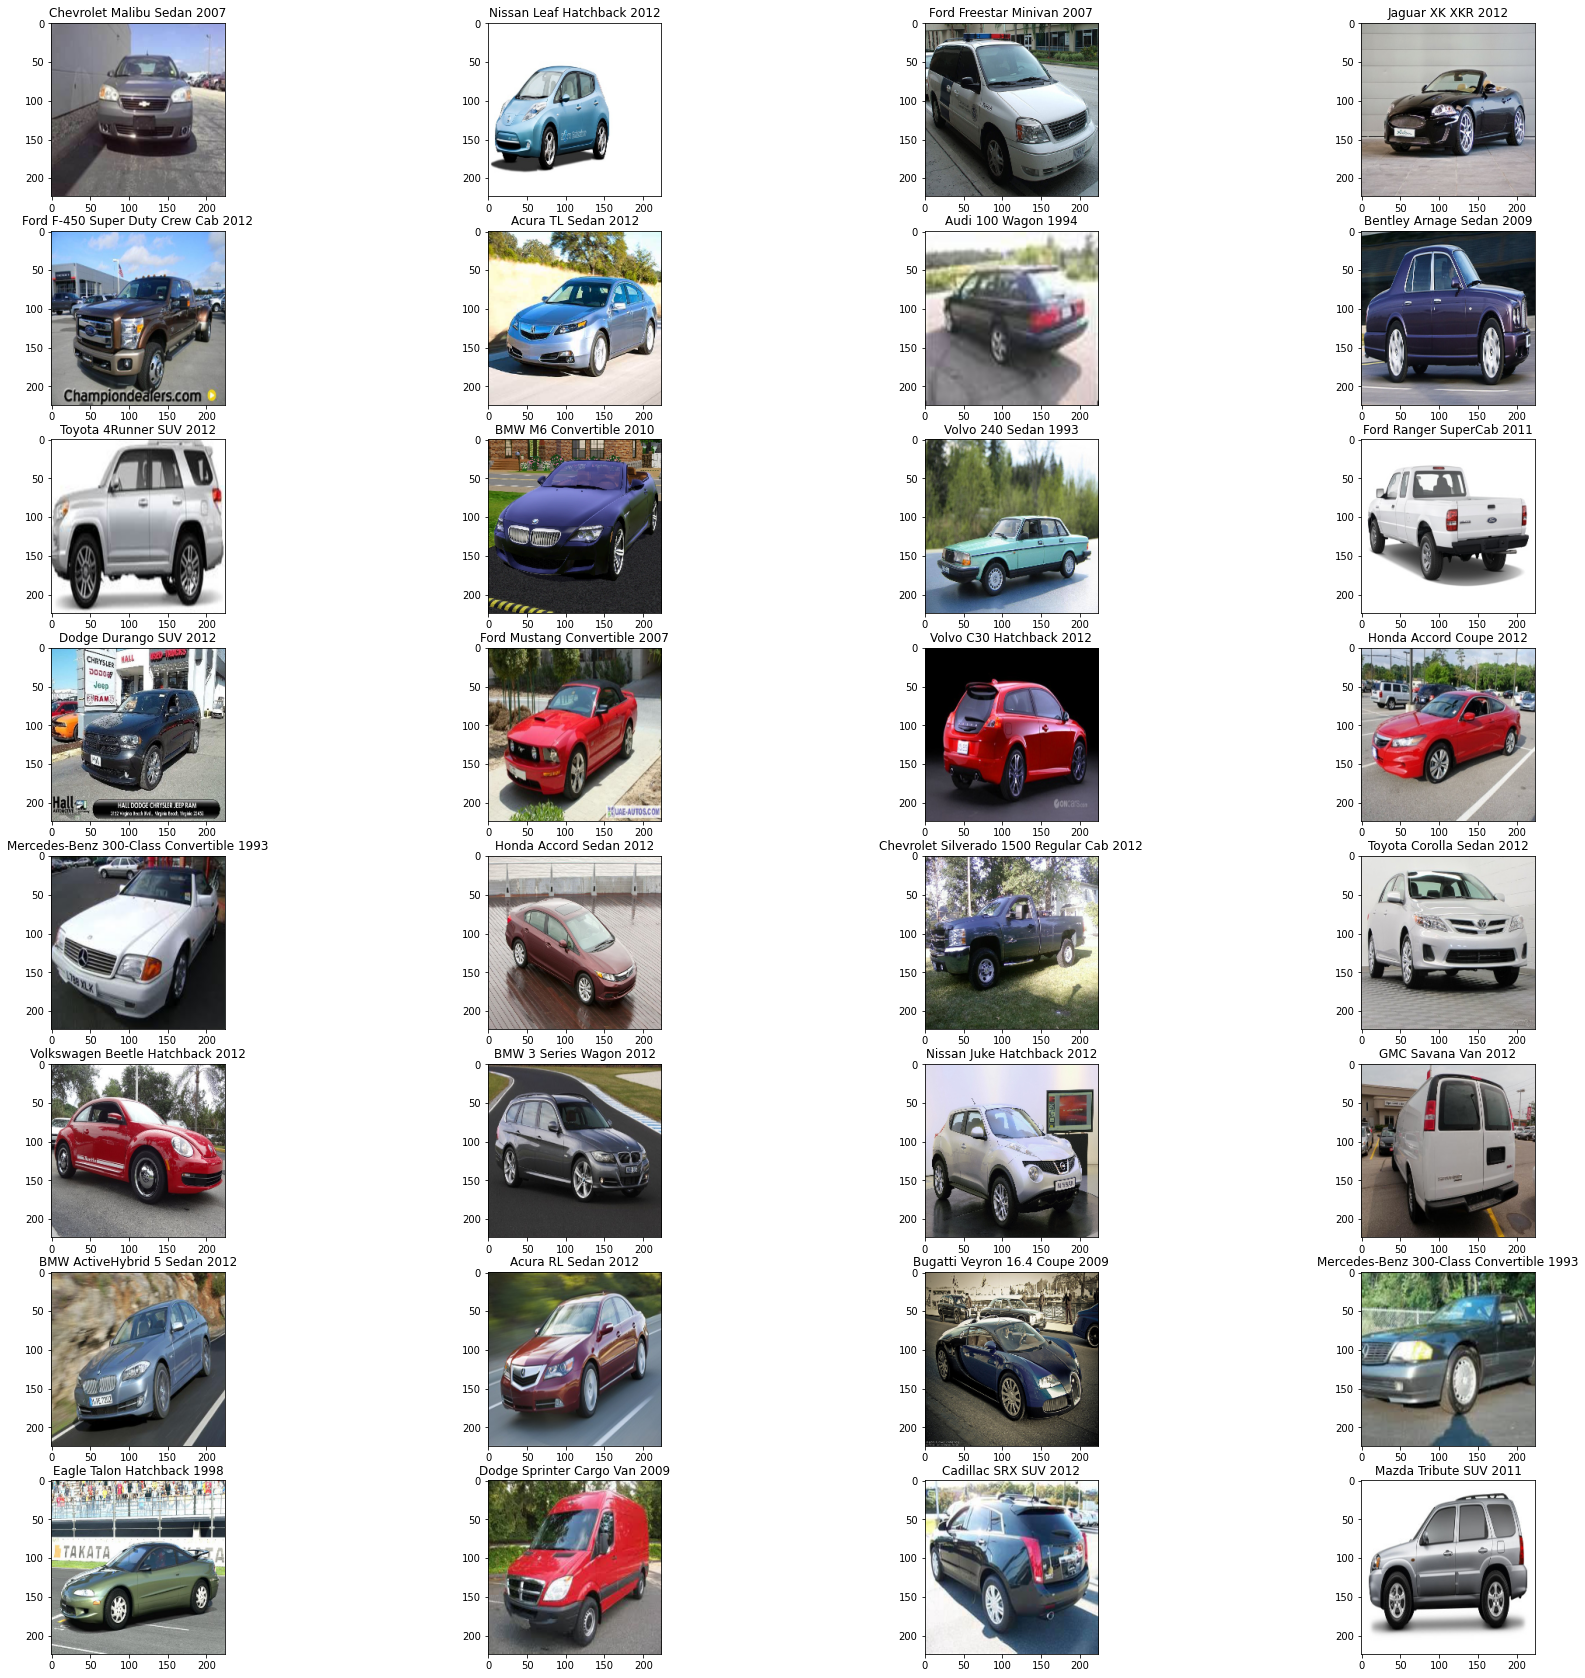

In [8]:
classes = list(train_data.class_to_idx)
test_loader=iter(test_data_loader)
image, labels = test_loader.next()
image=np.array(image)
nrows=8
ncols=4
plt.figure (figsize = (30, 30))
image = np.moveaxis(image, (0, 1, 2, 3), (0, 3, 1, 2))
for i in range(image.shape[0]):
    sp = plt.subplot(nrows, ncols, i+1)
    plt.imshow(image[i])
    plt.title(classes[int(labels[i])])
plt.show()

# Model trainer

In [9]:
dataloaders={
    'train':train_data_loader,
    'val': test_data_loader
}

dataset_sizes = {x: len(dataloaders[x]) for x in ['train', 'val']}

def save_checkpoint (state, filename):
    """ saving model's weights """
    print ('=> saving checkpoint')
    torch.save (state, filename)


def load_checkpoint (checkpoint, model):
    """ loading model's weights """
    print ('=> loading checkpoint')
    model.load_state_dict (checkpoint ['state_dict'])


def train_model(model, criterion, optimizer, num_epochs=10):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    train_accuracies = []
    train_losses = []
    val_accuracies = []
    val_losses = []

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            current_loss = 0.0
            current_corrects = 0

            # Here's where the training happens
            print('Iterating through data...')
            
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                # We need to zero the gradients, don't forget it
                optimizer.zero_grad()

                # Time to carry out the forward training poss
                # We only need to log the loss stats if we are in training phase
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    outputs = torch.squeeze(outputs)
                    loss = criterion(outputs.float(), labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                current_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                current_corrects += torch.sum(preds == labels.data)            


            epoch_loss = current_loss / dataset_sizes[phase]
            # epoch_acc = current_corrects.double() / dataset_sizes[phase]
            epoch_acc = 100/32*current_corrects/dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # Make a copy of the model if the accuracy on the validation set has improved
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            
            # Add metrics to history
            if phase == 'train':
                train_losses.append(epoch_loss)
                train_accuracies.append(epoch_acc)
            else:
                val_losses.append(epoch_loss)
                val_accuracies.append(epoch_acc)

        print()

    time_since = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_since // 60, time_since % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # Now we'll load in the best model weights and return it
    model.load_state_dict(best_model_wts)
    history = {
        'loss': train_losses,
        'accuracy': train_accuracies,
        'val_loss': val_losses,
        'val_accuracy': val_accuracies,
    }
    return model, history

# Common parts

In [10]:
class ResnetModel(nn.Module):
    def __init__(self, original_model, num_classes):
        super(ResnetModel, self).__init__()

        # Everything except the last linear layer
        self.features = nn.Sequential(*list(original_model.children())[:-1])
        self.classifier = nn.Sequential(
            nn.Linear(2048, num_classes),
        )
    def forward(self, x):
        f = self.features(x)
        f = f.view(f.size(0), -1)
        y = self.classifier(f)
        return y

In [11]:
def plot_results(acc, val_acc, loss, val_loss):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.tight_layout(pad=4)

    ax1.set_title('Accuracy')
    ax1.plot(acc)
    ax1.plot(val_acc)
    ax1.set_ylabel('accuracy')
    ax1.set_xlabel('epoch')
    ax1.legend(['training', 'validation'], loc='lower right')

    ax2.set_title('Loss')
    ax2.plot(loss)
    ax2.plot(val_loss)
    ax2.set_ylabel('loss')
    ax2.set_xlabel('epoch')
    ax2.legend(['training', 'validation'], loc='upper right')

    fig.show()

In [12]:
def print_num_params(model):
    pytorch_total_params = sum(p.numel() for p in model.parameters())
    pytorch_total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print('pytorch_total_params:', pytorch_total_params )
    print('pytorch_total_trainable_params:', pytorch_total_trainable_params)

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = len(classes)
EPOCHS = 15

# Part A
Trainable ResNet with random weights

Trainable NN classifier

In [14]:
resnet = models.resnet50(pretrained=False)
base_model_a = ResnetModel(resnet, num_classes)
print_num_params(base_model_a)

pytorch_total_params: 23909636
pytorch_total_trainable_params: 23909636


In [15]:
base_model_a = base_model_a.to(device)

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(base_model_a.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Train model
model_a, history_a = train_model(
    base_model_a,
    criterion,
    optimizer_ft,
    num_epochs=EPOCHS,
)

Epoch 0/14
----------
Iterating through data...
train Loss: 173.7111 Acc: 0.5392
Iterating through data...
val Loss: 169.3775 Acc: 1.0789

Epoch 1/14
----------
Iterating through data...
train Loss: 167.1350 Acc: 0.9681
Iterating through data...
val Loss: 165.0253 Acc: 1.2277

Epoch 2/14
----------
Iterating through data...
train Loss: 165.0545 Acc: 1.0784
Iterating through data...
val Loss: 164.5716 Acc: 0.8929

Epoch 3/14
----------
Iterating through data...
train Loss: 163.1095 Acc: 1.2745
Iterating through data...
val Loss: 165.4916 Acc: 1.7113

Epoch 4/14
----------
Iterating through data...
train Loss: 161.4277 Acc: 1.5809
Iterating through data...
val Loss: 160.5721 Acc: 2.5422

Epoch 5/14
----------
Iterating through data...
train Loss: 159.0842 Acc: 2.1936
Iterating through data...
val Loss: 158.6864 Acc: 2.3189

Epoch 6/14
----------
Iterating through data...
train Loss: 156.0988 Acc: 2.5735
Iterating through data...
val Loss: 174.9441 Acc: 1.9593

Epoch 7/14
----------
Itera

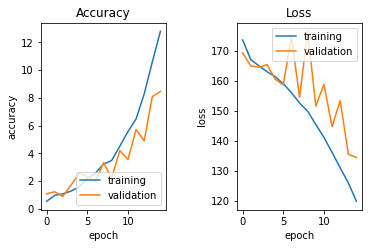

In [16]:
plot_results(
    acc=history_a['accuracy'],
    val_acc=history_a['val_accuracy'],
    loss=history_a['loss'],
    val_loss=history_a['val_loss'],
)

# Part B
ResNet (pretrained and freezed) as feature extractor

Simple trainable NN classifier

In [17]:
resnet = models.resnet50(pretrained=True)
base_model_b = ResnetModel(resnet, num_classes)

# Freeze all weights
for p in base_model_b.parameters():
    p.requires_grad = False

# Unfreeze classifer weights
for p in base_model_b.classifier[0].parameters():
    p.requires_grad = True

# Get trainable params
trainable_params_b = []
for name, param in base_model_b.named_parameters():
    if param.requires_grad:
        trainable_params_b.append(param)

print_num_params(base_model_b)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

pytorch_total_params: 23909636
pytorch_total_trainable_params: 401604


In [18]:
base_model_b = base_model_b.to(device)

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(trainable_params_b, lr=0.001)
criterion = nn.CrossEntropyLoss() 

# Train model
model_b, history_b = train_model(
    base_model_b,
    criterion,
    optimizer_ft,
    num_epochs=EPOCHS,
)

Epoch 0/14
----------
Iterating through data...
train Loss: 156.0890 Acc: 7.8309
Iterating through data...
val Loss: 126.3226 Acc: 16.8899

Epoch 1/14
----------
Iterating through data...
train Loss: 105.6626 Acc: 27.7941
Iterating through data...
val Loss: 108.8203 Acc: 25.4340

Epoch 2/14
----------
Iterating through data...
train Loss: 82.2829 Acc: 41.6667
Iterating through data...
val Loss: 99.3812 Acc: 28.9187

Epoch 3/14
----------
Iterating through data...
train Loss: 68.7571 Acc: 50.6250
Iterating through data...
val Loss: 96.5175 Acc: 30.0099

Epoch 4/14
----------
Iterating through data...
train Loss: 60.0066 Acc: 54.6201
Iterating through data...
val Loss: 91.4174 Acc: 31.9692

Epoch 5/14
----------
Iterating through data...
train Loss: 52.1281 Acc: 60.5760
Iterating through data...
val Loss: 91.5455 Acc: 32.7629

Epoch 6/14
----------
Iterating through data...
train Loss: 46.0958 Acc: 64.5466
Iterating through data...
val Loss: 90.2854 Acc: 34.3502

Epoch 7/14
----------
It

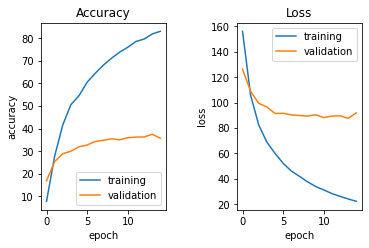

In [19]:
plot_results(
    acc=history_b['accuracy'],
    val_acc=history_b['val_accuracy'],
    loss=history_b['loss'],
    val_loss=history_b['val_loss'],
)

# Part D
Finetune on part B

In [20]:
# Copy model trained on part b
# ResNet initial weights coming from ImageNet
# Classifier weights coming from training on part b
base_model_d = copy.deepcopy(model_b)

# Unfreeze last conv block
# Other blocks (except classifier) remain freeze
for p in base_model_d.features[7].parameters():
    p.requires_grad = True

# Get trainable params
trainable_params_d = []
for name, param in base_model_d.named_parameters():
    if param.requires_grad:
        trainable_params_d.append(param)

print_num_params(base_model_d)

pytorch_total_params: 23909636
pytorch_total_trainable_params: 15366340


In [21]:
base_model_d = base_model_d.to(device)

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(trainable_params_d, lr=0.001)
criterion = nn.CrossEntropyLoss() 

# Train model
model_d, history_d = train_model(
    base_model_d,
    criterion,
    optimizer_ft,
    num_epochs=EPOCHS,
)

Epoch 0/14
----------
Iterating through data...
train Loss: 76.5675 Acc: 40.6250
Iterating through data...
val Loss: 59.8551 Acc: 49.1071

Epoch 1/14
----------
Iterating through data...
train Loss: 28.0584 Acc: 74.0319
Iterating through data...
val Loss: 51.8117 Acc: 56.1012

Epoch 2/14
----------
Iterating through data...
train Loss: 15.5853 Acc: 85.5760
Iterating through data...
val Loss: 51.2012 Acc: 59.6354

Epoch 3/14
----------
Iterating through data...
train Loss: 9.4082 Acc: 91.2990
Iterating through data...
val Loss: 47.5665 Acc: 61.5699

Epoch 4/14
----------
Iterating through data...
train Loss: 6.3858 Acc: 93.6765
Iterating through data...
val Loss: 49.2389 Acc: 61.8180

Epoch 5/14
----------
Iterating through data...
train Loss: 6.6462 Acc: 93.8848
Iterating through data...
val Loss: 54.2140 Acc: 59.1394

Epoch 6/14
----------
Iterating through data...
train Loss: 5.6449 Acc: 94.6324
Iterating through data...
val Loss: 49.5496 Acc: 62.5744

Epoch 7/14
----------
Iterating

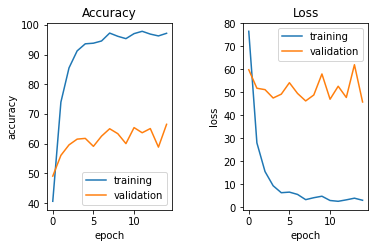

In [22]:
plot_results(
    acc=history_d['accuracy'],
    val_acc=history_d['val_accuracy'],
    loss=history_d['loss'],
    val_loss=history_d['val_loss'],
)

# Part E
Compare part A, B and D

In [23]:
def get_features(name, features):
    def hook(model, input, output):
        features[name] = output.detach()
    return hook

def get_layers_outputs(model, input):
    features = {}
    index = 0;
    for name, layer in model.named_modules():
        if 'conv' in name:
            temp_name = str(index) + "#" + name
            layer.register_forward_hook(get_features(temp_name, features))
            index += 1
    model = model.to(device)
    output = model(input)
    return features

def zero_total_ratio(model, input):
    features = get_layers_outputs(model, input)
    result = []
    for key in features.keys():
        layer_outputs = features[key]
        mask = torch.where(layer_outputs <= 0, 1, 0)
        zeros_count = torch.count_nonzero(mask).item()
        total_count = torch.numel(layer_outputs)
        ratio = zeros_count / total_count
        result.append(ratio)
    return result

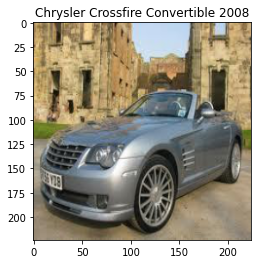

In [24]:
data_loader = iter(test_data_loader)
images, labels = data_loader.next()
image = images[0]
label = labels[0]

plt.imshow(image.permute(1, 2, 0))
plt.title(classes[label])
plt.show()

In [25]:
image_batch = image.reshape((1, *image.shape))
image_batch = image_batch.to(device)

In [26]:
# Random weights - part A
model = model_a
output = model(image_batch)
confidence, predict = torch.max(output.data, 1)

print(f'Model A predicted class: {classes[predict.item()]}')
print(f'Confidence: {confidence.item()}')

ratio_1 = zero_total_ratio(model, image_batch)

Model A predicted class: Acura TL Type-S 2008
Confidence: 2.920487642288208


In [27]:
# Feature extractor before fine tune - part B
model = model_b
output = model(image_batch)
confidence, predict = torch.max(output.data, 1)

print(f'Model B predicted class: {classes[predict.item()]}')
print(f'Confidence: {confidence.item()}')

ratio_2 = zero_total_ratio(model, image_batch)

Model B predicted class: Chrysler Crossfire Convertible 2008
Confidence: -2.653465509414673


In [28]:
# After fine tuning - part D
model = model_d
output = model(image_batch)
confidence, predict = torch.max(output.data, 1)

print(f'Model D predicted class: {classes[predict.item()]}')
print(f'Confidence: {confidence.item()}')

ratio_3 = zero_total_ratio(model, image_batch)

Model D predicted class: Chrysler Crossfire Convertible 2008
Confidence: 12.835813522338867


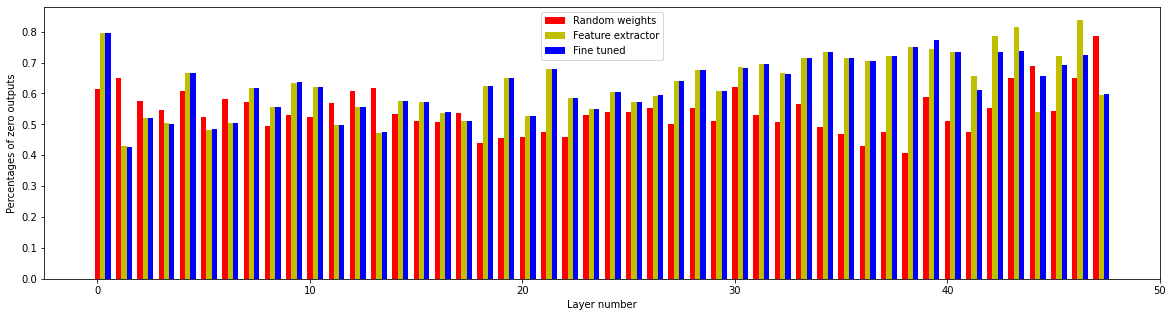

In [29]:
fig = plt.subplots(figsize=(20, 5))

bar1 = np.arange(len(ratio_1))
bar2 = [x + 0.25 for x in bar1]
bar3 = [x + 0.25 for x in bar2]
 
plt.bar(bar1, ratio_1, color='r', width=0.25, label="Random weights")
plt.bar(bar2, ratio_2, color='y', width=0.25, label="Feature extractor")
plt.bar(bar3, ratio_3, color='b', width=0.25, label="Fine tuned")

plt.xlabel('Layer number')
plt.ylabel('Percentages of zero outputs')
 
plt.legend()
plt.show()

# Part C
ResNet (pretrained and freezed) as feature extractor

SVM classifier

In [30]:
from sklearn.svm import SVC

In [31]:
class ResNetFeatureExtractor(nn.Module):
    def __init__(self, original_model):
        super(ResNetFeatureExtractor, self).__init__()
        # Everything except the last linear layer
        self.features = nn.Sequential(*list(original_model.children())[:-1])

    def forward(self, x):
        f = self.features(x)
        y = f.view(f.size(0), -1)
        return y

resnet = models.resnet50(pretrained=True)
base_model_c = ResNetFeatureExtractor(resnet)

# Freeze all weights
for p in base_model_c.parameters():
    p.requires_grad = False

base_model_c = base_model_c.to(device)

In [32]:
all_train_labels = []
all_train_features = []

all_test_labels = []
all_test_features = []

for inputs, labels in dataloaders['train']:
    inputs = inputs.to(device)
    labels = labels.to(device)
    features = base_model_c.forward(inputs)
    features = features.to(device)
    all_train_labels += labels.tolist()
    all_train_features += features.tolist()
    

for inputs, labels in dataloaders['val']:
    inputs = inputs.to(device)
    labels = labels.to(device)
    features = base_model_c.forward(inputs)
    features = features.to(device)
    all_test_labels += labels.tolist()
    all_test_features += features.tolist()

In [33]:
# Polynomial
clf = SVC(kernel='poly', verbose=1)

In [34]:
# Train
clf.fit(
    all_train_features,
    all_train_labels,
)

[LibSVM]

SVC(kernel='poly', verbose=1)

In [35]:
# Evaluation
acc_train = clf.score(all_train_features, all_train_labels)
acc_test = clf.score(all_test_features, all_test_labels)

In [36]:
print(f'Train accuracy: {acc_train * 100} %')
print(f'Test accuracy: {acc_test * 100} %')

Train accuracy: 100.0 %
Test accuracy: 34.6723044397463 %
